# Clients churn

Clients started leaving the bank. Every month. A little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. We have historical data on customer behavior and termination of agreements with the bank.

Our task is to build a model with *F1*-measure value of at least 0.59.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Our key steps:
* Data preparation
* Research task. Training different models without taking into account imbalance
* Fight imbalance. Training Different Models Given Imbalance
* Model testing
* Checking the model for sanity
* Checking AUC-ROC metric

**Data description**  

**Features**

* *RowNumber* — row index in the data 
* *CustomerId* — unique customer ID 
* *Surname* - surname 
* *CreditScore* - credit score 
* *Geography* - country of residence 
* *Gender* - gender 
* *Age* — age 
* *Tenure* - how many years a person has been a client of the bank 
* *Balance* — account balance 
* *NumOfProducts* - the number of bank products used by the client 
* *HasCrCard* - the presence of a credit card 
* *IsActiveMember* — client activity 
* *EstimatedSalary* — estimated salary

**Target feature** 

**Exited** — the fact that the client has left


The project is made in **Jupyter Notebook**, Notebook server version: 6.1.4. Version **Python** 3.7.8.
  
Libraries used in the project:
* **Pandas**
* **NumPy**
* **MatPlotLib**
* **scikit-learn**
* **IPython**

## Data preparation

In [1]:
# Import all required libraries and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

# Read the data.
data = pd.read_csv('Churn.csv', index_col=0)
display(data.head(5))

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [2]:
# Much more convenient when the column names
# are written in capital letters. 
data.columns = data.columns.str.lower()
# For convenience, let's translate the data format of the Tenure feature into Int64.
# This format allows you to get rid of unnecessary number display
# floating point, and leave gaps (NaN values).
data.tenure = data.tenure.astype('Int64')
# Let's review the dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       10000 non-null  int64  
 1   surname          10000 non-null  object 
 2   creditscore      10000 non-null  int64  
 3   geography        10000 non-null  object 
 4   gender           10000 non-null  object 
 5   age              10000 non-null  int64  
 6   tenure           9091 non-null   Int64  
 7   balance          10000 non-null  float64
 8   numofproducts    10000 non-null  int64  
 9   hascrcard        10000 non-null  int64  
 10  isactivemember   10000 non-null  int64  
 11  estimatedsalary  10000 non-null  float64
 12  exited           10000 non-null  int64  
dtypes: Int64(1), float64(2), int64(7), object(3)
memory usage: 1.1+ MB


In [3]:
# The tenure feature has objects with NaN-values.
# This will interfere with training our model.
# It will not be possible to fill in the missing values correctly.
# Remove rows containing missing values.
data = data.dropna().reset_index(drop=True)
# Check if the dataset has row duplicates.
print('Row duplicates number is', 
      data.duplicated().sum())
# Columns with customerid and surname attributes
# don't make sense for machine learning.
# Get rid of them.
data = data.drop(['customerid', 'surname'], axis=1)
display(data)

Row duplicates number is 0


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9086,800,France,Female,29,2,0.00,2,0,0,167773.55,0
9087,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9088,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9089,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [4]:
# The dataframe has both numeric and categorical features.
# Let's use the technique of one-hot encoding.
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.head(5))
data_ohe.info()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        9091 non-null   int64  
 1   age                9091 non-null   int64  
 2   tenure             9091 non-null   Int64  
 3   balance            9091 non-null   float64
 4   numofproducts      9091 non-null   int64  
 5   hascrcard          9091 non-null   int64  
 6   isactivemember     9091 non-null   int64  
 7   estimatedsalary    9091 non-null   float64
 8   exited             9091 non-null   int64  
 9   geography_Germany  9091 non-null   uint8  
 10  geography_Spain    9091 non-null   uint8  
 11  gender_Male        9091 non-null   uint8  
dtypes: Int64(1), float64(2), int64(6), uint8(3)
memory usage: 674.8 KB


In [5]:
# Prepare training, validation and test sets.
features = data_ohe.drop('exited', axis=1)
target = data_ohe.exited

In the `train_test_split` method, we use the `stratify` parameter. Specify in it a set of objects of the target feature. This will keep the ratio of objects of different classes in the splitted sets the same as in the `target` set.

In [6]:
# First, split into training and validation.
# Validation set size 0.2.
features_train, features_valid, target_train, target_valid = train_test_split(
    features,
    target, 
    test_size=.2,
    random_state=12345,
    stratify=target
)
# Now we split the training set into test and
# the final version of the training set.
features_train, features_test, target_train, target_test = train_test_split(
    features_train,
    target_train, 
    test_size=.25,
    random_state=12345,
    stratify=target_train
)

In [7]:
# Scale numerical features.
numeric_features = [
    'creditscore', 
    'age', 
    'tenure', 
    'balance', 
    'estimatedsalary'
]
scaler = StandardScaler()
scaler.fit(features_train[numeric_features]) 
features_train[numeric_features] = scaler.transform(
    features_train[numeric_features]
)
features_valid[numeric_features] = scaler.transform(
    features_valid[numeric_features]
)
features_test[numeric_features] = scaler.transform(
    features_test[numeric_features]
)
pd.options.mode.chained_assignment = None
display(features_train.head(5))
# Sets are ready. Let's take a look at their sizes.
# We remember that the original dataset had
# 13 features and 9091 objects.
samples = [
    features_train, target_train, 
    features_valid, target_valid, 
    features_test, target_test
]
for sample in samples:
    display(sample.shape)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
2804,0.273332,-1.028943,-0.344468,-1.224804,2,1,1,0.776365,0,0,0
4445,0.867258,0.197898,0.688936,1.669480,1,1,1,0.650528,0,0,1
8537,-0.133038,-0.745826,-0.688936,0.357605,1,0,0,-1.368629,0,0,0
1588,-1.362568,-0.085219,0.000000,0.555184,1,0,1,0.638830,0,0,1
5744,0.867258,1.047250,-1.033403,-1.224804,2,0,1,0.822454,0,0,1


(5454, 11)

(5454,)

(1819, 11)

(1819,)

(1818, 11)

(1818,)

### Conclusion

We prepared the following data:
* For the convenience of writing code, the height of the letters in the names of features has been reduced
* *tenure* column data format converted to `int64`. This allowed us to get rid of the meaningless floating point
* Due to the impossibility of correctly filling in the missing values in the *tenure* feature, it was decided to get rid of rows with missing values. The presence of missing values will interfere with the correct training of the mathematical model.
* We checked for row duplicates. There were no duplicates in the dataset.
* Due to the fact that there is no need for the features *customerid* and *surname*, we got rid of them
* Using the One-Hot Encoding, we translated the categorical features expressed in words into numerical ones
* Using the `train_test_split` method, we splitted the dataset into three sets: training, validation and test in the classical ratio: 0.6 / 0.2 / 0.2
* Using the `scaler.transform` method, scaling of the numerical features *creditscore*, *age*, *tenure*, *balance*, *estimatedsalary* was performed

## Research task. Training different models without taking into account imbalance

0    0.796113
1    0.203887
Name: exited, dtype: float64

<AxesSubplot:>

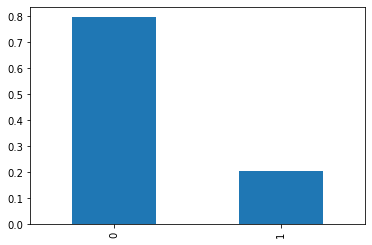

In [8]:
# Estimate the ratio of classes.
display(target_train.value_counts(normalize=True))
target_train.value_counts(normalize=True).plot(kind='bar')

Accuracy of the logistic regression model before class balancing is 0.8136338647608576
Accuracy of the dummy model is 0.7960620393796062

Confusion matrix
[[1393   55]
 [ 284   87]]

Recall of the logistic regression model before class balancing is 0.23450134770889489
Precision of the logistic regression model before class balancing is 0.6126760563380281
F1-score of the logistic regression model before class balancing is 0.33918128654970764



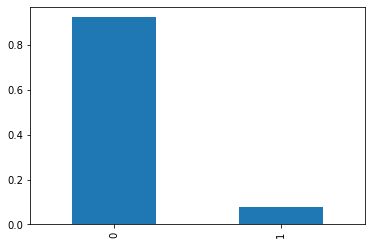

In [9]:
# Train different models without class imbalance
# Let's start with logistic regression.
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid = pd.Series(model_lr.predict(features_valid))
predicted_valid.value_counts(normalize=True).plot(kind='bar')
# Calculate the value of accuracy.
accuracy_valid =  accuracy_score(target_valid, predicted_valid)
print('Accuracy of the logistic regression model' + 
      ' before class balancing is', accuracy_valid)
# Check the model for sanity. Let's create a constant model.
dummy_regr = DummyRegressor(strategy="constant", constant=0)
dummy_regr.fit(features, target)
target_pred_constant = pd.Series(dummy_regr.predict(features))
print('Accuracy of the dummy model is', 
      accuracy_score(target, target_pred_constant))
print()
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of the logistic regression model' + 
      ' before class balancing is', 
      recall_score(target_valid, predicted_valid))
print('Precision of the logistic regression model' +
      ' before class balancing is', 
      precision_score(target_valid, predicted_valid))
print('F1-score of the logistic regression model' +
      ' before class balancing is', 
      f1_score(target_valid, predicted_valid))
print()

It is worth noting that feature standardization does not make sense for decision trees. But to shorten the code, we will use a standardized training set to train the decision trees too.

In [10]:
# Train the decision tree without taking into account the imbalance.
# First, set the max_depth hyperparameter.
for depth in range(1, 11):
    model_dt = DecisionTreeClassifier(
        random_state=12345, max_depth=depth
    ) 
    model_dt.fit(features_train, target_train)
    predictions_valid = model_dt.predict(features_valid)
    print('max_depth =', depth, ': ', end='')
    print(accuracy_score(target_valid, predictions_valid))
# Now train the decision tree.
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=5) 
model_dt.fit(features_train, target_train)
predicted_valid = model_dt.predict(features_valid)
accuracy_valid =  accuracy_score(target_valid, predicted_valid)
print('Accuracy of the decision tree model' +
      ' before class balancing is', accuracy_valid)
# Check the model for sanity. Let's create a constant model.
dummy_dt = DummyClassifier(strategy="constant", constant=0)
dummy_dt.fit(features, target)
target_pred_dt = pd.Series(dummy_dt.predict(features))
print('Accuracy of constant dummy model is', 
      accuracy_score(target, target_pred_dt))
print()
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of the decision tree model' +
      ' before class balancing is', 
      recall_score(target_valid, predicted_valid))
print('Precision of the decision tree model' +
      ' before class balancing is', 
      precision_score(target_valid, predicted_valid))
print('F1-score of the decision tree model' +
      ' before class balancing is', 
      f1_score(target_valid, predicted_valid))
print()

max_depth = 1 : 0.7960417811984607
max_depth = 2 : 0.8367234744365035
max_depth = 3 : 0.8427707531610775
max_depth = 4 : 0.8510170423309511
max_depth = 5 : 0.8587135788894997
max_depth = 6 : 0.8581638262781748
max_depth = 7 : 0.8510170423309511
max_depth = 8 : 0.8499175371083013
max_depth = 9 : 0.8367234744365035
max_depth = 10 : 0.8152831225948324
Accuracy of the decision tree model before class balancing is 0.8587135788894997
Accuracy of constant dummy model is 0.7960620393796062

Confusion matrix
[[1421   27]
 [ 230  141]]

Recall of the decision tree model before class balancing is 0.38005390835579517
Precision of the decision tree model before class balancing is 0.8392857142857143
F1-score of the decision tree model before class balancing is 0.5231910946196661



In [11]:
# Train a random forest.
# First, set up the n_estimators hyperparameter.
best_model = None
best_result = 0
for est in range(1, 41):
    model = RandomForestClassifier(
        random_state=12345, 
        n_estimators=est
    )
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
    print(est, best_result)
print('Accuracy of the best model on the validation set:', 
      best_result)
print()
# Train the model.
model_rf = RandomForestClassifier(
    random_state=12345, n_estimators=38
) 
model_rf.fit(features_train, target_train)
predicted_valid = model_rf.predict(features_valid)
accuracy_valid =  accuracy_score(target_valid, predicted_valid)
print('The accuracy of our model prior to class balancing is', 
      accuracy_valid)
# Check the model for sanity. Let's create a constant model.
dummy_rf = DummyClassifier(strategy="constant", constant=0)
dummy_rf.fit(features, target)
target_pred_rf = pd.Series(dummy_rf.predict(features))
print('Accuracy of constant dummy model is', 
      accuracy_score(target, target_pred_rf))
print()
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of the random forest model' +
      ' before class balancing is', 
      recall_score(target_valid, predicted_valid))
print('Precision of the random forest model' + 
      ' before class balancing is', 
      precision_score(target_valid, predicted_valid))
print('F1-score of the random forest model' +
      ' before class balancing is', 
      f1_score(target_valid, predicted_valid))
print()

1 0.7932930181418362
2 0.8295766904892798
3 0.8295766904892798
4 0.8433205057724025
5 0.8433205057724025
6 0.8433205057724025
7 0.8433205057724025
8 0.8444200109950523
9 0.8444200109950523
10 0.8499175371083013
11 0.8499175371083013
12 0.8532160527762507
13 0.8532160527762507
14 0.8532160527762507
15 0.8532160527762507
16 0.8532160527762507
17 0.8532160527762507
18 0.8548653106102254
19 0.8548653106102254
20 0.8559648158328752
21 0.8559648158328752
22 0.857064321055525
23 0.857064321055525
24 0.8581638262781748
25 0.8581638262781748
26 0.8581638262781748
27 0.8581638262781748
28 0.8581638262781748
29 0.8581638262781748
30 0.8581638262781748
31 0.8581638262781748
32 0.8581638262781748
33 0.8581638262781748
34 0.8581638262781748
35 0.8581638262781748
36 0.8581638262781748
37 0.8581638262781748
38 0.8598130841121495
39 0.8598130841121495
40 0.8598130841121495
Accuracy of the best model on the validation set: 0.8598130841121495

The accuracy of our model prior to class balancing is 0.85981

### Conclusion

We estimated the ratio of classes in the training sample: a negative class occurs 4 times more often than a positive one. The same ratio is observed in the validation set. It can be concluded that there is an imbalance of classes.
  
Without class imbalance, three different models were trained with three different algorithms:
  
**Logistic regression**
Accuracy of our model was 0.81. At the same time, the accuracy of the constant dummy model is 0.8. The accuracy of our model is almost equal to the accuracy of the dummy model. These results indicate the insanity of our model.
Recall was 0.23
Precision was 0.61
F1 score was 0.34
  
**Decision Tree**
Accuracy of our model was 0.86. At the same time, the accuracy of the constant dummy model is 0.8. Accuracy of our model is slightly higher than the empty model.
Recall was 0.38
Precision was 0.84
F1 score was 0.52
  
**Random Forest**
Accuracy of our model was 0.86. At the same time, the accuracy of the constant dummy model is 0.8. Accuracy of our model is slightly higher than the empty model.
Recall was 0.48
Precision was 0.74
F1 score was 0.58
  
**To increase the key metric, F1-measure, we need to balance the classes. This is what we will devote the next step of the project to.**

## Fight imbalance. Training Different Models Given Imbalance

### Logistic Regression

#### Method #1: Use the class_weight parameter

In [12]:
# Let's start our fight against imbalance. Train the Model
# with a logistic regression algorithm.
# Let's not forget to specify balanced in the class_weight parameter.
model_lr_2 = LogisticRegression(
    random_state=12345, 
    solver='liblinear', 
    class_weight='balanced'
)
model_lr_2.fit(features_train, target_train)
predicted_valid = model_lr_2.predict(features_valid)
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing is', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class balancing is', 
      precision_score(target_valid, predicted_valid))
print('F1-score of our model after class balancing is', 
      f1_score(target_valid, predicted_valid))

Confusion matrix
[[1021  427]
 [ 113  258]]

Recall of our model after class balancing is 0.6954177897574124
Precision of our model after class balancing is 0.37664233576642336
F1-score of our model after class balancing is 0.48863636363636365


#### Method #2: Upsampling

In [13]:
# Let's use the method of increasing the sample
# by increasing the number of
# feature objects of a less common class.
# Write an upsample function that takes as input
# target and other signs, as well as a multiplier.
def upsample(features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    
    features_upsampled = pd.concat(
        [features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat(
        [target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# Get new samples.
features_upsampled, target_upsampled = upsample(
    features_train, 
    target_train,
    4
)
# Check sizes.
print(features_upsampled.shape)
print(target_upsampled.shape)
print()
print(target_upsampled.value_counts())
print()
# Create a model and train it.
model_lr_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_3.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr_3.predict(features_valid)
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing' +
      ' with Upsampling method is', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class balancing' + 
      ' with Upsampling method is', 
      precision_score(target_valid, predicted_valid))
print('F1-мера of our model after class balancing' + 
      ' with Upsampling method is', 
      f1_score(target_valid, predicted_valid))

(8790, 11)
(8790,)

1    4448
0    4342
Name: exited, dtype: int64

Confusion matrix
[[1007  441]
 [ 111  260]]

Recall of our model after class balancing with Upsampling method is 0.7008086253369272
Precision of our model after class balancing with Upsampling method is 0.37089871611982883
F1-мера of our model after class balancing with Upsampling method is 0.48507462686567165


#### Метод #3: Downsampling

In [14]:
# Use the downsampling method
# by reducing the number of feature objects
# of the class that occurs most frequently.
# Write a downsample function that takes as input
# target and other features, as well as a multiplier.
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + 
        [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + 
        [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# Get new samples.
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25
)
# Check sizes.
print(features_downsampled.shape)
print(target_downsampled.shape)
print()
print(target_downsampled.value_counts())
print()
# Create a model and train it.
model_lr_4 = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_4.fit(features_downsampled, target_downsampled)
predicted_valid = model_lr_4.predict(features_valid)
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing' + 
      ' with Downsampling is', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class balancing' +
      ' with Downsampling is', 
      precision_score(target_valid, predicted_valid))
print('F1-score of our model after class balancing' +
      ' with Downsampling is', 
      f1_score(target_valid, predicted_valid))

(2198, 11)
(2198,)

1    1112
0    1086
Name: exited, dtype: int64

Confusion matrix
[[1016  432]
 [ 115  256]]

Recall of our model after class balancing with Downsampling is 0.6900269541778976
Precision of our model after class balancing with Downsampling is 0.37209302325581395
F1-score of our model after class balancing with Downsampling is 0.48347497639282344


#### Conclusion

The values of the F1-score of the logistic regression model for each method of dealing with imbalances were:
* Using class_weight = 'balanced' parameter: F1-score is 0.489
* Applying the Upsampling technique: F1-score is 0.485
* Applying the Downsampling technique: F1-score is 0.483

Balancing the training dataset allowed us to significantly increase the F1-score, no matter how we fought the imbalance. However, we failed to achieve the set task (F1-score with a value of at least 0.59). Let's try other algorithms.

### Decision Tree

#### Method #1: Using the class_weight Parameter

In [15]:
# Train the model with the decision tree algorithm
# Let's not forget to specify balanced in the class_weight parameter.
model_dt_2 = DecisionTreeClassifier(
    random_state=12345, 
    max_depth=6, 
    class_weight='balanced'
) 
model_dt_2.fit(features_train, target_train)
predicted_valid = model_dt_2.predict(features_valid)
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing is', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class modeling', 
      precision_score(target_valid, predicted_valid))
print('F1-score of our model after class modeling', 
      f1_score(target_valid, predicted_valid))

Confusion matrix
[[1044  404]
 [  76  295]]

Recall of our model after class balancing is 0.7951482479784366
Precision of our model after class modeling 0.4220314735336195
F1-score of our model after class modeling 0.5514018691588786


#### Method #2: Upsampling

In [16]:
# Let's use the method of increasing the sample
# by increasing the number of objects
# signs of a less common class.
model_dt_3 = DecisionTreeClassifier(
    random_state=12345, 
    max_depth=6
) 
model_dt_3.fit(features_upsampled, target_upsampled)
predicted_valid = model_dt_3.predict(features_valid)
# Calculate main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing' +
      ' with the Upsampling method is', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class balancing' +
      ' with the Upsampling method is', 
      precision_score(target_valid, predicted_valid))
print('F1-score of our model after class balancing' +
      ' with the Upsampling method is', 
      f1_score(target_valid, predicted_valid))

Confusion matrix
[[1044  404]
 [  76  295]]

Recall of our model after class balancing with the Upsampling method is 0.7951482479784366
Precision of our model after class balancing with the Upsampling method is 0.4220314735336195
F1-score of our model after class balancing with the Upsampling method is 0.5514018691588786


#### Method #3: Downsampling

In [17]:
# We will use the method of Downsampling by reducing the number
# of objects of the class that occurs most frequently.
model_dt_4 = DecisionTreeClassifier(
    random_state=12345, 
    max_depth=6
) 
model_dt_4.fit(features_downsampled, target_downsampled)
predicted_valid = model_dt_4.predict(features_valid)
# Calculate confusion matrix.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing' +
      ' with the Downsampling method is', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class balancing' +
      ' with the Downsampling method is', 
      precision_score(target_valid, predicted_valid))
print('F1-score of our model after class balancing' + 
      ' with the Downsampling method is', 
      f1_score(target_valid, predicted_valid))

Confusion matrix
[[1056  392]
 [  86  285]]

Recall of our model after class balancing with the Downsampling method is 0.7681940700808625
Precision of our model after class balancing with the Downsampling method is 0.42097488921713444
F1-score of our model after class balancing with the Downsampling method is 0.5438931297709922


#### Conclusion

The values of the F1-score of the decision tree model for each way to deal with the imbalance were:
* Using class_weight = 'balanced' parameter: F1-score is 0.551
* Applying the Upsampling technique: F1-score is 0.551
* Applying the Downsampling technique: F1-score is 0.544

Balancing the training data allowed us to increase the F1-score, no matter how we fought the imbalance. However, we failed to achieve the set task (F1-score with a value of at least 0.59). Let's try to apply the random forest algorithm.

### Random forest

#### Метод № 1: использование параметра class_weight

In [18]:
# Train the model with the random forest algorithm
# Let's not forget to specify balanced in the class_weight parameter.
model_rf_2 = RandomForestClassifier(
    random_state=12345, 
    n_estimators=38, 
    class_weight='balanced'
) 
model_rf_2.fit(features_train, target_train)
predicted_valid = model_rf_2.predict(features_valid)
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class balancing', 
      precision_score(target_valid, predicted_valid))
print('F1-score of our model after class balancing', 
      f1_score(target_valid, predicted_valid))

Confusion matrix
[[1399   49]
 [ 196  175]]

Recall of our model after class balancing 0.4716981132075472
Precision of our model after class balancing 0.78125
F1-score of our model after class balancing 0.588235294117647


#### Method #2: Upsampling

In [19]:
# We will use the method of Upsampling due to
# increasing the number of feature objects of a less common class.
model_rf_3 =  RandomForestClassifier(random_state=12345, n_estimators=38) 
model_rf_3.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf_3.predict(features_valid)
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing' + 
      ' with the Upsampling method is', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class balancing' +
      ' with the Upsampling method is', 
      precision_score(target_valid, predicted_valid))
print('F1-score of our model after class balancing' + 
      ' with the Upsampling method is', 
      f1_score(target_valid, predicted_valid))

Confusion matrix
[[1346  102]
 [ 162  209]]

Recall of our model after class balancing with the Upsampling method is 0.5633423180592992
Precision of our model after class balancing with the Upsampling method is 0.6720257234726688
F1-score of our model after class balancing with the Upsampling method is 0.6129032258064516


#### Method #3: Downsampling

In [20]:
# We will use the method of Downsampling by reducing the number
# of objects of the class that occurs most frequently.
model_rf_4 = RandomForestClassifier(random_state=12345, n_estimators=38) 
model_rf_4.fit(features_downsampled, target_downsampled)
predicted_valid = model_rf_4.predict(features_valid)
# Calculate the main metrics.
print('Confusion matrix')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall of our model after class balancing' +
      ' with the Downsampling method', 
      recall_score(target_valid, predicted_valid))
print('Precision of our model after class balancing' + 
      ' with the Downsampling method', 
      precision_score(target_valid, predicted_valid))
print('F1-score of our model after class balancing' +
      ' with the Downsampling method', 
      f1_score(target_valid, predicted_valid))

Confusion matrix
[[1144  304]
 [  94  277]]

Recall of our model after class balancing with the Downsampling method 0.7466307277628033
Precision of our model after class balancing with the Downsampling method 0.47676419965576594
F1-score of our model after class balancing with the Downsampling method 0.5819327731092437


#### Conclusion

The values of the F1-score of the random forest model for each method of dealing with imbalances were:
* Using class_weight = 'balanced' parameter: F1-score is 0.548
* Applying the Upsampling technique: F1-score is 0.613
* Applying the Downsampling technique: F1-score is 0.582

Balancing the training dataset made it possible to increase the F1-score using the Upsampling imbalance control technique. We managed to achieve an F1-score of at least 0.59.

### The results of the fight against imbalance

The highest value of the F1-score (0.613) was achieved when using the Upsampling technique in a model with a random forest algorithm (number of estimators - 38). Let's test this model on a test sample.

## Model testing

In [21]:
model = RandomForestClassifier(random_state=12345, n_estimators=38) 
model.fit(features_upsampled, target_upsampled)

predicted_test = model.predict(features_test)
accuracy_test =  accuracy_score(target_test, predicted_test)
print('Accuracy of our model is', accuracy_test)
print('Recall of our model is', 
      recall_score(target_test, predicted_test))
print('Precision of our model is', 
      precision_score(target_test, predicted_test))
print('F1-score of our model is', 
      f1_score(target_test, predicted_test))
print('Confusion matrix')
print(confusion_matrix(target_test, predicted_test))

Accuracy of our model is 0.8514851485148515
Recall of our model is 0.5283018867924528
Precision of our model is 0.6735395189003437
F1-score of our model is 0.5921450151057401
Confusion matrix
[[1352   95]
 [ 175  196]]


In [22]:
# Let's check our model for sanity.
dummy_rf_test = DummyClassifier(strategy="constant", constant=0)
dummy_rf_test.fit(features_upsampled, target_upsampled)
target_pred_dummy_rf_test = pd.Series(
    dummy_rf_test.predict(features_test)
)
accuracy_test_dummy_rf_test =  accuracy_score(
    target_test, target_pred_dummy_rf_test
)
print('Accuracy of the dummy model is', accuracy_test_dummy_rf_test)
if accuracy_test_dummy_rf_test < accuracy_test:
    print('Our model is sane.')
else:
    print('Model is insane. Improvement required.')

Accuracy of the dummy model is 0.7959295929592959
Our model is sane.


In [23]:
# Let's take a look at the feature_importances attribute to understand which features
# are most related to the target feature and which are least related.
# Let's create a function for viewing the importance of features.
def importance(model):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features) 
    importance.sort_values(ascending=False).plot(
        kind='bar', 
        x=importance.index, 
        y=importance,
        title='Feature importances bar chart')

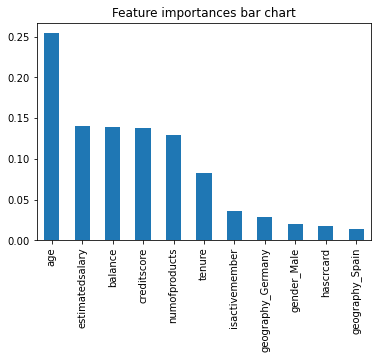

In [24]:
# Let's check an importance of the features.
importance(model)

### Conclusion

Our random forest model showed a successful result: the required value of the F1-score was reached - 0.592.
Our model parameters:
1. Algorithm: random forest
2. Hyperparameters: random_state=12345, n_estimators=38
3. The features and target sets are processed by the OHE technique.
4. The imbalance is taken into account using the Upsampling technique
  
Thanks to the feature_importances attribute, we figured out which features are most closely related to the target feature and which are not.
Thus, the feature creditscore is extremely important for the predictions that our model makes. This means that we must monitor the quality of the collected data for this trait.
The least important features were hascrcard, geography_Germany, geography_Spain, gender_Male. 
  
Now let's study the AUC-ROC metric

## Checking AUC-ROC metric

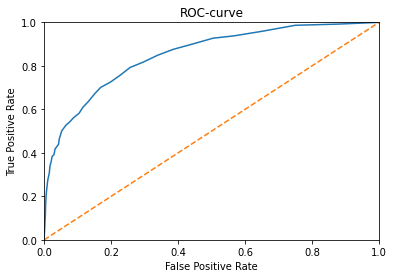


AUC-ROC is 0.8509882888101976


In [25]:
# Plot the curve.
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC-curve')
plt.show()
print()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC is', auc_roc)

### Conclusion

The AUC-ROC value was 0.851, which is significantly more than 0.5. Recall that the value of the F1-score was 0.592.
These values are relatively high, which means that our model is of relatively high quality even at different classification thresholds.

## General conclusion

We have built a model that allows us to determine with a fairly high quality whether a client will leave the bank in the near future or not.
We successfully prepared the data, fought the imbalance and provided the necessary values for the main metrics:
* F1-score was 0.592
* AUC-ROC was 0.851

The relatively high values of the main metrics tell us about the rather high quality of our model.